# Random structure generation and analysis

We can also try generating random multilayers and sorting good performing ones for further optimization.
Since we are considering two different objectives, $\eta_T$ and $\eta_R$, we might imagine that 
some [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) might be of value.  We will define 
a function `is_dominated()` will take an array containing $\eta_T$ and $\eta_R$ values 
arising from a set of randomly-generated structures and will identify all structures that are dominated by other structures.  This is essentially the complementary list of structures that are Pareto optimal; namely this will identify all structures that **do not** lie on the Pareto front.  We can then create the Pareto front as the complement list and choose to investigate structures from this list.

The function `is_dominated` sorts out the indices of dominated structures.

In [45]:
def is_dominated(eta_T, eta_R):
    '''Pareto optimal: structure x with transmission efficiency \eta_T(x) and
       reflection efficiency \eta_R(x) is pareto optimal if for all y \neq x
       \eta_T(x) ≥ \eta_T(y) and \eta_R(x) ≥ \eta_R(y)
       and \eta_T(x) > \eta_T(y) or \eta_R(x) > \eta_R(y)'''
    _N = len(eta_T)
    _is_dominated = []
    for i in range(0, _N):
        _eta_T_x = eta_T[i]
        _eta_R_x = eta_R[i]
        for j in range(0, _N):
            if j != i:
                _eta_T_y = eta_T[j]
                _eta_R_y = eta_R[j]
                if _eta_T_y >= _eta_T_x and _eta_R_y >= _eta_R_x:
                    if _eta_T_y > _eta_T_x or _eta_R_y > _eta_R_x:
                        _is_dominated.append(i)
                        break
    return _is_dominated
             
    

Next we will create a base structure with 5 transparent layers on top of a thin silver film
using `"Material_List": ["Air","Ta2O5", "SiO2", "Al2O3", "SiO2", "Al2O3", "Ag", "Air"]` and
`"Thickness_List": [0, 70e-9, 85e-9, 70e-9, 85e-9, 500e-9, 2e-9, 0]`.
We will specify that layers 1 through 5 can be randomly modified in thickness and composition
using the lines
`"random_material_layers" : [1, 2, 3, 4, 5]` and `"random_thickness_layers" : [1, 2, 3, 4, 5]`.
Finally, the materials from which the composition can be randmoly selected is specified 
in `"possible_random_materials" : ["SiO2", "Al2O3", "Ta2O5", "TiO2", "ZrO2", "Si3N4"]`.

The structure will be instantiated as the Ta2O45, SiO2, Al2O3, SiO2, Al2O3, Ag structure as specified below,
and we will randomly modify the layers in a subsequent cell.

In [46]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np

test_args = {
    "wavelength_list": [300e-9, 6000e-9, 1000],
    "Material_List": ["Air","Ta2O5", "SiO2", "Al2O3", "SiO2", "Al2O3", "Ag", "Air"],
    "Thickness_List": [0, 70e-9, 85e-9, 70e-9, 85e-9, 500e-9, 2e-9, 0],
    "reflective_window_wn" : [2000, 2400],
    "transmissive_window_nm" : [350, 700],
    "random_material_layers" : [1, 2, 3, 4, 5],
    "random_thickness_layers" : [1, 2, 3, 4, 5],
    "possible_random_materials" : ["SiO2", "Al2O3", "Ta2O5", "TiO2", "ZrO2", "Si3N4"]
 }

sf = wptherml.SpectrumFactory()
test = sf.spectrum_factory('Tmm', test_args)

test.compute_selective_mirror_fom()
print(F'Reflection Efficiency is {100 * test.reflection_efficiency:.2f} %')
print(F'Transmission Efficiency is {100 * test.transmission_efficiency:.2f} %')
print(F'Composite FOM is {100 * test.selective_mirror_fom:.2f} %')


 Your spectra have been computed! 😎 
Reflection Efficiency is 19.12 %
Transmission Efficiency is 64.56 %
Composite FOM is 41.84 %


We will plot the spectra of this initial structure along a wavenumber and wavelength axis below.

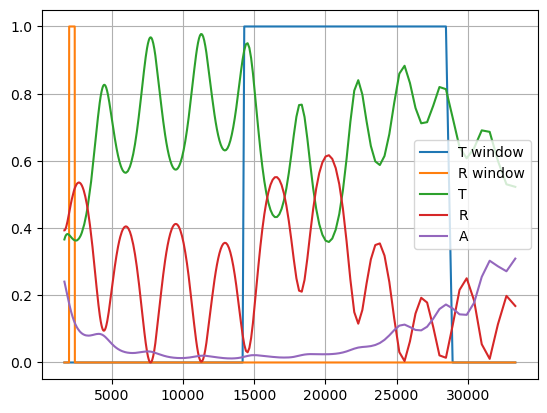

In [47]:


plt.plot(test.wavenumber_array * 1e-2, test.transmissive_envelope, label='T window')
plt.plot(test.wavenumber_array * 1e-2, test.reflective_envelope, label='R window')
plt.plot(test.wavenumber_array * 1e-2, test.transmissivity_array, label='T')
plt.plot(test.wavenumber_array * 1e-2, test.reflectivity_array, label='R')
plt.plot(test.wavenumber_array * 1e-2, test.emissivity_array, label='A')
#plt.xlim(2000,8000)
plt.grid(True)
plt.legend()

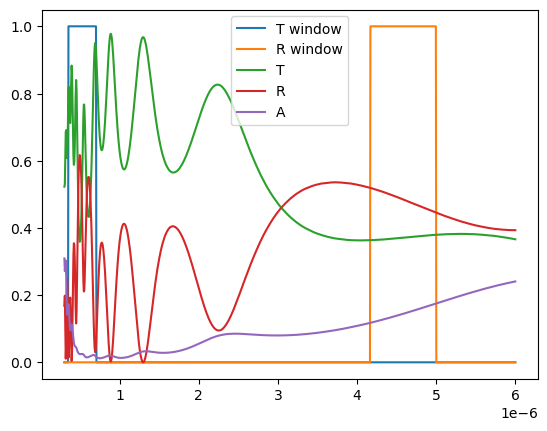

In [48]:
plt.plot(test.wavelength_array, test.transmissive_envelope, label='T window')
plt.plot(test.wavelength_array, test.reflective_envelope, label='R window')
plt.plot(test.wavelength_array, test.transmissivity_array, label='T')
plt.plot(test.wavelength_array, test.reflectivity_array, label='R')
plt.plot(test.wavelength_array, test.emissivity_array, label='A')
#plt.xlim(400e-9,800e-9)
plt.legend()


#plt.xlim(1000, 3000)

The block below will create a number of random structures (specified by `N = 500` currently).
The compositions and thicknesses of layers 1-5 will be randomly assigned by the lines
`test.randomize_materials_array()` and `test.randomize_thickness_array()`, and we will compute
and store the values of $\eta_T$ and $\eta_R$ for each one.  We will also store integer codes
for the materials (these codes are just the indices corresponding to the materials from the 
`possible_random_materials` list, e.g. for `"possible_random_materials" : ["SiO2", "Al2O3", "Ta2O5", "TiO2", "ZrO2", "Si3N4"]`, $0 \rightarrow {\rm SiO2}, 1 \rightarrow {\rm Al2O3}, {\rm etc}$ which will help us to store and retrieve information about the Pareto optimal structures later.

In [67]:
N = 500
M = len(test.random_materials_list)
foms = np.zeros((N, 2))
thicknesses = np.zeros((N, test.number_of_layers))
materials_codes = np.zeros((N, M), dtype=int)

for i in range(0, N):
    test.randomize_materials_array()
    test.randomize_thickness_array()
    thicknesses[i,:] = np.copy(test.thickness_array)
    materials_codes[i,:] = np.copy(test.materials_code)
    test.compute_spectrum()
    test.compute_selective_mirror_fom()
    # get objectives Pareto dominant solutions
    foms[i,0] = test.reflection_efficiency 
    foms[i,1] = test.transmission_efficiency 

You can print all of the randomly-generated thickness and materials code lists here

In [68]:
print(thicknesses)
print(materials_codes)


[[0.00e+00 6.38e-07 3.39e-07 ... 8.35e-07 2.00e-09 0.00e+00]
 [0.00e+00 1.20e-07 8.40e-08 ... 4.31e-07 2.00e-09 0.00e+00]
 [0.00e+00 7.40e-08 1.20e-07 ... 9.12e-07 2.00e-09 0.00e+00]
 ...
 [0.00e+00 1.93e-07 4.72e-07 ... 6.44e-07 2.00e-09 0.00e+00]
 [0.00e+00 4.77e-07 3.59e-07 ... 8.18e-07 2.00e-09 0.00e+00]
 [0.00e+00 4.01e-07 7.00e-08 ... 5.14e-07 2.00e-09 0.00e+00]]
[[4 4 3 4 0]
 [1 3 1 0 5]
 [3 4 2 1 0]
 ...
 [1 5 3 5 5]
 [2 4 4 4 5]
 [1 1 2 0 2]]


We will now sort the dominated structures in order to create the list of Pareto optimal solutions, which 
will be plotted ($\eta_R$ vs $\eta_T$) along with all structures below.

In [69]:
# get the indices of all solutions that are dominated by at least 1 other solution
dominated_indices = is_dominated(foms[:,0], foms[:,1])

# collect the Pareto front as the solutions which are *NOT* dominated by any others
pareto_foms = np.delete(foms, dominated_indices, axis=0)
pareto_materials = np.delete(materials_codes, dominated_indices, axis=0)
pareto_thicknesses = np.delete(thicknesses, dominated_indices, axis=0)


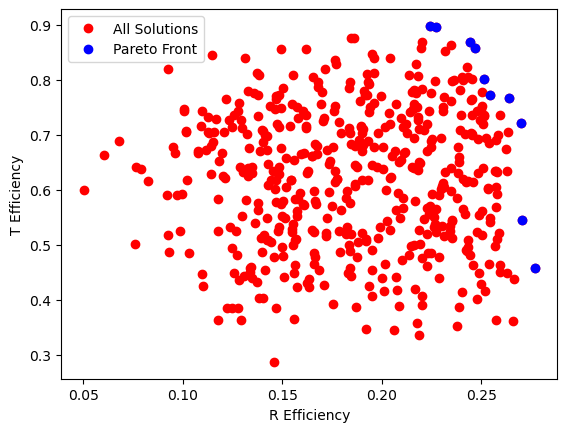

In [70]:
plt.plot(foms[:,0], foms[:,1], 'ro', label="All Solutions")
plt.plot(pareto_foms[:,0],  pareto_foms[:,1], 'bo', label="Pareto Front")
plt.xlabel("R Efficiency")
plt.ylabel("T Efficiency")
plt.legend()
plt.show()

Let's plot the spectrum of the Pareto optimal solution that has the maximum R efficiency

In [71]:
# get the index of the solution with the largest value of \eta
max_R_index = np.argmax(pareto_foms[:,0])
print(max_R_index)
max_T_index = np.argmax(pareto_foms[:,1])
print(max_T_index)

3
2


We can easily get the thickness list for each of these solutions, but the materials list is
going to take slightly more work... we have the material codes (indices) and must use them along
with the `possible_materials` and `random_materials_list` attributes 

In [72]:
# get the thickness array for the Pareto solution that maximizes R efficiency / minimizes R error
test.thickness_array = np.copy(pareto_thicknesses[max_T_index])

In [73]:
for i in range(len(pareto_materials[max_T_index])):
    idx = pareto_materials[max_T_index, i]
    mat_str = test.possible_materials[idx]
    jdx = test.random_materials_list[i]
    test.material_array[jdx] = mat_str
print(test.material_array)

['Air', 'SiO2', 'Si3N4', 'Al2O3', 'Si3N4', 'SiO2', 'Ag', 'Air']


In [74]:
print(test.thickness_array)

[0.00e+00 9.00e-08 1.61e-07 3.16e-07 3.38e-07 3.68e-07 2.00e-09 0.00e+00]


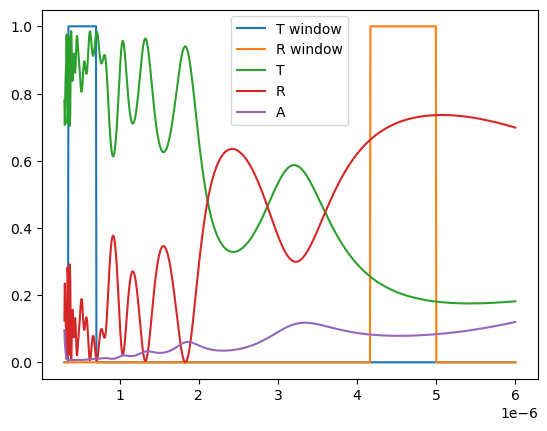

In [75]:
test.set_refractive_index_array()
test.compute_spectrum()

plt.plot(test.wavelength_array, test.transmissive_envelope, label='T window')
plt.plot(test.wavelength_array, test.reflective_envelope, label='R window')
plt.plot(test.wavelength_array, test.transmissivity_array, label='T')
plt.plot(test.wavelength_array, test.reflectivity_array, label='R')
plt.plot(test.wavelength_array, test.emissivity_array, label='A')
plt.legend()
